# Loading word embeddings

In [25]:
import io
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips
from persim import plot_diagrams, bottleneck, sliced_wasserstein
from tqdm.notebook import tqdm

In [2]:
language_keys = {
# "latin": "la",
"greek": "el",
# "anglo": "an",
"korean": "ko",
"japanese" : "ja",
"chinese": "zh",
"turkish":"tr",
"norwegian":"no",
"catalan":"ca",
"romanian":"ro",
# "basque": "eu",
"dutch": "nl",
"sweden": "sv",
"russian": "ru",
"polish":"pl",
"english": "en",
"bulgarian":"bg",
"hungarian":"hu",
"finish":"fi",
"french":"fr",
"italian": "it",
"german":"de",
# "navajo":"nv",
"arabic":"ar",
"hindi":"hif",
"english": "en",
"spanish": "es"
}

# la
# an
# eu
# nv

from collections import defaultdict

cross_dict_dir = "data/crosslingual/dictionaries/"

In [3]:
len(language_keys)

22

In [31]:
class Tree:
    def __init__(self, data, left=None, right=None):
        self.left = left 
        self.right = right
        self.data = data
    def __str__(self):
        return "Data: %s" % self.data

    @staticmethod
    def node_list(root):
        nlist = []
        queue = [root]
        while len(queue) > 0:
            node = queue.pop()
            if node.left:
                queue.append(node.left)
            if node.right:
                queue.append(node.right)
            else:
                nlist.append(node)
        return nlist
    
    def display(self, keys):
        lines, *_ = self._display_aux(keys)
        for line in lines:
            print(line)

    def _display_aux(self, keys):
        """Returns list of strings, width, height, and horizontal coordinate of the root."""
        # No child.
        if self.right is None and self.left is None:
            line = keys[self.data]
            width = len(line)
            height = 1
            middle = width // 2
            return [line], width, height, middle

        # Only left child.
        if self.right is None:
            lines, n, p, x = self.left._display_aux(keys)
            s = keys[self.data]
            u = len(s)
            first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s
            second_line = x * ' ' + '/' + (n - x - 1 + u) * ' '
            shifted_lines = [line + u * ' ' for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, n + u // 2

        # Only right child.
        if self.left is None:
            lines, n, p, x = self.right._display_aux(keys)
            s = keys[self.data]
            u = len(s)
            first_line = s + x * '_' + (n - x) * ' '
            second_line = (u + x) * ' ' + '\\' + (n - x - 1) * ' '
            shifted_lines = [u * ' ' + line for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, u // 2

        # Two children.
        left, n, p, x = self.left._display_aux(keys)
        right, m, q, y = self.right._display_aux(keys)
        s = keys[self.data]
        u = len(s)+1
        first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s + y * '_' + (m - y) * ' '
        second_line = x * ' ' + '/' + (n - x - 1 + u + y) * ' ' + '\\' + (m - y - 1) * ' '
        if p < q:
            left += [n * ' '] * (q - p)
        elif q < p:
            right += [m * ' '] * (p - q)
        zipped_lines = zip(left, right)
        lines = [first_line, second_line] + [a + u * ' ' + b for a, b in zipped_lines]
        return lines, n + m + u, max(p, q) + 2, n + u // 2


def distance_matrix(nodes, tiny_dmatrix):
    """
    Computes distance matrix with complete linkage 
    """
    d_matrix = np.full((len(nodes), len(nodes)), np.nan)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            nlist_1 = Tree.node_list(nodes[i])
            nlist_2 = Tree.node_list(nodes[j])
            ids_1 = [node.data for node in nlist_1]
            ids_2 = [node.data for node in nlist_2]
            d_matrix[i,j] = max([tiny_dmatrix[i,j] for i in ids_1 for j in ids_2])
            d_matrix[i,j] = max([tiny_dmatrix[i,j] for i in ids_1 for j in ids_2])
    return d_matrix


def distance_matrix_all(nodes, tiny_dmatrix, dgrms):
    """
    Computes distance matrix with complete linkage 
    """
    d_matrix = np.full((len(nodes), len(nodes)), np.nan)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if isinstance(nodes[i], Tree) and not isinstance(nodes[j], Tree):
                nlist = Tree.node_list(nodes[i])
                ids = [node.data for node in nlist]
                d_matrix[i,j] = max([[tiny_dmatrix[i,j] for i in ids] for j in ids])
            elif isinstance(nodes[j], Tree) and not isinstance(nodes[i], Tree): 
                nlist = Tree.node_list(nodes[j])
                ids = [node.data for node in nlist]
                d_matrix[i,j] = max([[tiny_dmatrix[i,j] for i in ids] for j in ids])
            elif isinstance(nodes[i], Tree) and isinstance(nodes[j], Tree):
                nlist_1 = Tree.node_list(nodes[i])
                nlist_2 = Tree.node_list(nodes[j])
                ids_1 = [node.data for node in nlist_1]
                ids_2 = [node.data for node in nlist_2]
                d_matrix[i,j] = max([[tiny_dmatrix[i,j] for i in ids_1] for j in ids_2])
            else: 
                d_matrix[i,j] = bottleneck(dgrms[nodes[i].data], dgrms[nodes[j].data])
            d_matrix[j,i] = d_matrix[i,j]
        return d_matrix
    
def hclustering(dgrms, homology=0, dist='sw'):
    nodes = [Tree(i) for i in range(len(dgrms))]
    new_dgrms = [dgrms[i][homology] for i in dgrms]
    tiny_dmatrix = np.full((len(nodes), len(nodes)), np.nan)                
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if dist == 'sw':
                tiny_dmatrix[i,j] = sliced_wasserstein(new_dgrms[nodes[i].data], new_dgrms[nodes[j].data])
            else:
                tiny_dmatrix[i,j] = bottleneck(new_dgrms[nodes[i].data], new_dgrms[nodes[j].data])
            tiny_dmatrix[j,i] = tiny_dmatrix[i,j]
#     langs = list(dgrms.keys())
#     langs.append('')
    while len(nodes) > 1:
#         a =[print(node) for node in nodes]
#         a = [node.display(langs) for node in nodes]
        d_matrix = distance_matrix(nodes, tiny_dmatrix)
#         print(d_matrix)
        i, j = np.unravel_index(np.nanargmin(d_matrix), d_matrix.shape)
        print("The minimum is ", d_matrix[i,j])
        node = Tree(-1, left=nodes[i], right=nodes[j])
        nodes = [nodes[k] for k in range(len(nodes)) if k not in [i,j]]
        nodes.append(node)        
    return nodes[0], tiny_dmatrix
    
def hclustering_all(dgrms, dist='sw'):
    nodes = [Tree(i) for i in range(len(dgrms))]
#     new_dgrms = [dgrms[i][homology] for i in dgrms]
    new_dgrms = [np.vstack((dgrms[i][0], dgrms[i][1], dgrms[i][2])) for i in dgrms]
    tiny_dmatrix = np.full((len(nodes), len(nodes)), np.nan)                
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if dist == 'sw':
                tiny_dmatrix[i,j] = sliced_wasserstein(new_dgrms[nodes[i].data], new_dgrms[nodes[j].data])
            else:
                tiny_dmatrix[i,j] = bottleneck(new_dgrms[nodes[i].data], new_dgrms[nodes[j].data])
            tiny_dmatrix[j,i] = tiny_dmatrix[i,j]
    langs = list(dgrms.keys())
    langs.append('')
    while len(nodes) > 1:
#         a =[print(node) for node in nodes]
        a = [node.display(langs) for node in nodes]
        d_matrix = distance_matrix_all(nodes, tiny_dmatrix, new_dgrms)
        i, j = np.unravel_index(np.nanargmin(d_matrix), d_matrix.shape)
        print("The minimum is ", d_matrix[i,j])
        node = Tree(None, left=nodes[i], right=nodes[j])
        nodes = [nodes[k] for k in range(len(nodes)) if k not in [i,j]]
        nodes.append(node)        
    return nodes[0], tiny_dmatrix


def make_latex_tree(tree,langs):
    print(chr(92)+'begin{forest}\n[',end='')
    _make_latex_tree(tree,langs)
    print(']\n'+ chr(92) +'end{forest}',end='')

    
def _make_latex_tree(tree, langs):
    if not tree.left and not tree.right:
        print(langs[tree.data], end='')
    elif tree.data:
        print('|[', end='')
        _make_latex_tree(tree.left,langs)
        print(']',end='')
        print('[',end='')
        _make_latex_tree(tree.right,langs)
        print(']',end='')

In [4]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

# en-es.0-5000.txt     en-ru.0-5000.txt     fr-es.0-5000.txt     pt-de.0-5000.txt
# bn-en.5000-6500.txt               en-es.5000-6500.txt

def load_dict(dict_path="data/crosslingual/dictionaries/en-es.0-5000.txt"):
    
    return pd.read_csv(dict_path, names=["src", "tgt"], delim_whitespace=True)


def multi_key_dict(words, dict_):
    out = []
    for word in words:
        if word in dict_:
            out.append(dict_[word])
    return np.asarray(out)


def update_dict(dict_, keys, values, lang):
    for i in range(len(keys)):
        key = keys[i]
        value = values[i]
        if key in dict_:
            try:
                dict_[key][lang] += [value]
            except:
                import pdb; pdb.set_trace()
        else:
            dict_[key] = defaultdict(lambda: [])
            dict_[key][lang] = [value]
    return dict_


def filter_noverlap_words(vocab_old_en, vocab_old_lang, en_to_lang):
    vocab_new = []
    for i, word in enumerate(vocab_old_en):
        if word in en_to_lang and len(en_to_lang[word]) >= 22:
            vocab_new.append(vocab_old_lang[i])
        else:
            en_to_lang.pop(word, None)
    return vocab_new

from random import randint

def sample_in_all_langs(en_to_lang, num_samps=500):
    keys =  np.array(list(en_to_lang.keys()))
    print(keys)
    perm = np.random.permutation(len(keys))
    keys = keys[perm]
    
    words_per_lang = defaultdict(lambda: [])
    for i in range(num_samps):
        for lang in en_to_lang[keys[i]]:
            lst = en_to_lang[keys[i]][lang]
            num = randint(0, len(lst)-1)
            item = lst[num]
            words_per_lang[lang].append(item)
    return words_per_lang
    

In [5]:
en_to_lang = {}

for language, key_ in language_keys.items():
    
    if key_ == "hif": key_ = "hi"
    try:
        pds = load_dict("data/crosslingual/dictionaries/en-{0}.0-5000.txt".format(key_))
    except:
        print(key_)
        continue
    
    update_dict(en_to_lang, pds.src.values, pds.tgt.values , key_)

In [6]:
lang_vocab = {}

for language, key_ in language_keys.items():
    
    if key_ == "hif": key_ = "hi"
    try:#
        pds = load_dict("data/crosslingual/dictionaries/en-{0}.0-5000.txt".format(key_))
    except:
        print(key_)
        continue
    
    lang_vocab[key_] = filter_noverlap_words(pds.src.values, pds.tgt.values,  en_to_lang)

In [7]:
list(map(len , lang_vocab.values()))

[4836,
 3779,
 3320,
 4056,
 4558,
 4263,
 2784,
 5207,
 4104,
 5049,
 4987,
 5681,
 2023,
 4752,
 4323,
 5435,
 4594,
 4133,
 6417,
 5446,
 4088,
 5114]

In [8]:
en_to_lang["dog"]

defaultdict(<function __main__.update_dict.<locals>.<lambda>()>,
            {'el': ['σκύλος', 'σκυλί'],
             'ko': ['개그'],
             'ja': ['イヌ'],
             'zh': ['竇', '犬', '狗'],
             'tr': ['köpek'],
             'no': ['bikkje', 'hund', 'bikkja'],
             'ca': ['gos'],
             'ro': ['câine', 'dog', 'caine'],
             'nl': ['hond', 'hondje'],
             'sv': ['hund'],
             'ru': ['собака', 'пес', 'пёс'],
             'pl': ['psie', 'psy', 'pies', 'piesek'],
             'en': ['dog'],
             'bg': ['куче', 'кучето', 'дог'],
             'hu': ['kutyus', 'kutya'],
             'fi': ['koiran', 'koira'],
             'fr': ['chiens', 'chien', 'chienne'],
             'it': ['cane'],
             'de': ['hund', 'hunde', 'hündin'],
             'ar': ['الكلب', 'كلب'],
             'hi': ['डॉग', 'कुत्ता', 'कुत्ते', 'श्वान'],
             'es': ['perrita', 'perro', 'perros']})

In [12]:
samps =  sample_in_all_langs(en_to_lang,num_samps=800)

['from' 'this' 'but' ... 'registration' 'trans' 'terrorist']


In [13]:
len(en_to_lang)

2023

In [14]:
list(map(len, samps.values()))

[800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800,
 800]

In [15]:
# load en-xx dictionaries for subword selection
sub_sampled_embedings_per_lang = {}
word2id_per_lang = {}
id2word_per_lang = {}

nmax = 50000  # maximum number of word embeddings to load


# Load reduced dictionaries for each language lang based on the en-lang dictionaries
for language, key_ in language_keys.items():
    
    
    embeddings, id2word_per_lang[key_] , word2id_per_lang[key_]= load_vec('data/wiki.{0}.vec'.format(key_), nmax)
#     if key_ == "hif": key_ = "hi"
    ids = multi_key_dict(samps["hi" if key_=="hif" else key_],  word2id_per_lang[key_])
    sub_sampled_embedings_per_lang[key_] = embeddings[ids,:]
    
    del embeddings
    
    print(language)

greek
korean
japanese
chinese
turkish
norwegian
catalan
romanian
dutch
sweden
russian
polish
english
bulgarian
hungarian
finish
french
italian
german
arabic
hindi
spanish


In [16]:
sub_sampled_embedings_per_lang.keys()

dict_keys(['el', 'ko', 'ja', 'zh', 'tr', 'no', 'ca', 'ro', 'nl', 'sv', 'ru', 'pl', 'en', 'bg', 'hu', 'fi', 'fr', 'it', 'de', 'ar', 'hif', 'es'])

In [17]:
sub_sampled_embedings_per_lang["en"].shape, len(sub_sampled_embedings_per_lang)

((800, 300), 22)

In [24]:
diagrams_per_lang = {}
rips_per_lang = {}
for language, key_ in language_keys.items():
    rips = Rips(maxdim=2)
    rips_per_lang[language] = rips
    data = sub_sampled_embedings_per_lang["en"]
    diagrams = rips.fit_transform(data, metric="cosine")
    diagrams_per_lang[language] = diagrams
    


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbos

In [ ]:
import pickle as pkl

pkl.dump(diagrams_per_lang, open("dgms_800.pkl", "wb"))

In [33]:
class Tree:
    def __init__(self, data, left=None, right=None):
        self.left = left 
        self.right = right
        self.data = data

    def __str__(self):
        return "Node value is %s" % (self.data)

    @staticmethod
    def node_list(root):
        nlist = []
        queue = [root]
        while len(queue) > 0:
            node = queue.pop()
            if node.left:
                queue.append(node.left)
            if node.right:
                queue.append(node.right)
            else:
                nlist.append(node)
        return nlist

    def display(self):
        lines, *_ = self._display_aux()
        for line in lines:
            print(line)

    def _display_aux(self):
        """Returns list of strings, width, height, and horizontal coordinate of the root."""
        # No child.
        if self.right is None and self.left is None:
            line = '%s' % self.data
            width = len(line)
            height = 1
            middle = width // 2
            return [line], width, height, middle

        # Only left child.
        if self.right is None:
            lines, n, p, x = self.left._display_aux()
            s = '%s' % self.data
            u = len(s)
            first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s
            second_line = x * ' ' + '/' + (n - x - 1 + u) * ' '
            shifted_lines = [line + u * ' ' for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, n + u // 2

        # Only right child.
        if self.left is None:
            lines, n, p, x = self.right._display_aux()
            s = '%s' % self.data
            u = len(s)
            first_line = s + x * '_' + (n - x) * ' '
            second_line = (u + x) * ' ' + '\\' + (n - x - 1) * ' '
            shifted_lines = [u * ' ' + line for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, u // 2

        # Two children.
        left, n, p, x = self.left._display_aux()
        right, m, q, y = self.right._display_aux()
        s = '%s' % self.data
        u = len(s)
        first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s + y * '_' + (m - y) * ' '
        second_line = x * ' ' + '/' + (n - x - 1 + u + y) * ' ' + '\\' + (m - y - 1) * ' '
        if p < q:
            left += [n * ' '] * (q - p)
        elif q < p:
            right += [m * ' '] * (p - q)
        zipped_lines = zip(left, right)
        lines = [first_line, second_line] + [a + u * ' ' + b for a, b in zipped_lines]
        return lines, n + m + u, max(p, q) + 2, n + u // 2


def distance_matrix(nodes, tiny_dmatrix, dgrms):
    """
    Computes distance matrix with complete linkage 
    """
    d_matrix = np.full((len(nodes), len(nodes)), np.nan)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if isinstance(nodes[i], Tree) and not isinstance(nodes[j], Tree):
                nlist = Tree.node_list(nodes[i])
                ids = [node.data for node in nlist]
                d_matrix[i,j] = max([[tiny_dmatrix[i,j] for i in ids] for j in ids])
            elif isinstance(nodes[j], Tree) and not isinstance(nodes[i], Tree): 
                nlist = Tree.node_list(nodes[j])
                ids = [node.data for node in nlist]
                d_matrix[i,j] = max([[tiny_dmatrix[i,j] for i in ids] for j in ids])
            elif isinstance(nodes[i], Tree) and isinstance(nodes[j], Tree):
                nlist_1 = Tree.node_list(nodes[i])
                nlist_2 = Tree.node_list(nodes[j])
                ids_1 = [node.data for node in nlist_1]
                ids_2 = [node.data for node in nlist_2]
                d_matrix[i,j] = max([[tiny_dmatrix[i,j] for i in ids_1] for j in ids_2])
            else: 
                d_matrix[i,j] = bottleneck(dgrms[nodes[i].data], dgrms[nodes[j].data])
            d_matrix[j,i] = d_matrix[i,j]
        return d_matrix
    
def hclustering(dgrms, homology=0):
    nodes = [Tree(i) for i in range(len(dgrms))]
    new_dgrms = [dgrms[i][homology] for i in dgrms]
    tiny_dmatrix = np.full((len(nodes), len(nodes)), np.nan)                
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            tiny_dmatrix[i,j] = bottleneck(new_dgrms[nodes[i].data], new_dgrms[nodes[j].data])
    while len(nodes) > 1:
        print(nodes)
        d_matrix = distance_matrix(nodes, tiny_dmatrix, new_dgrms)
        i, j = np.unravel_index(np.argmin(d_matrix), d_matrix.shape)
        node = Tree(None, left=nodes.pop(i), right=nodes.pop(j))
        nodes.append(node)        
    return nodes[0]

In [ ]:
q_, tiny = hclustering(diagrams_per_lang)
langs = list(dgrms.keys())
langs.append('')

C:\Users\vargf\anaconda3\lib\site-packages\persim\bottleneck.py:53: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
C:\Users\vargf\anaconda3\lib\site-packages\persim\bottleneck.py:63: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


In [32]:
q_, tiny = hclustering_all(diagrams_per_lang)
langs = list(dgrms.keys())
langs.append('')

greek
korean
japanese
chinese
turkish
norwegian
catalan
romanian
dutch
sweden
russian
polish
english
bulgarian
hungarian
finish
french
italian
german
arabic
hindi
spanish


ValueError: setting an array element with a sequence.

In [ ]:
q1, tiny = hclustering(dgrms,homology=1,dist='sw');

In [ ]:
q1.display(langs)

In [ ]:
make_latex_tree(q1,langs)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
68.00771355628967


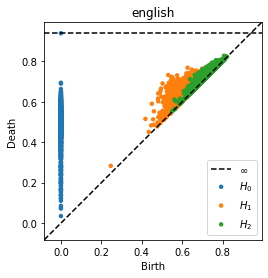

In [18]:
import time

start = time.time()

rips = Rips(maxdim=2)
data = sub_sampled_embedings_per_lang["en"]
diagrams = rips.fit_transform(data, metric="cosine")
rips.plot(diagrams)
plt.title("english")

end = time.time()
print(end - start)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Text(0.5, 1.0, 'spanish')

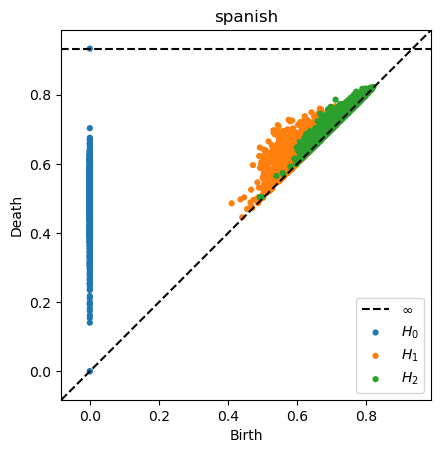

In [19]:
# %%time
rips_2 = Rips(maxdim=2)
data_2 = sub_sampled_embedings_per_lang["es"]
diagrams_2 = rips_2.fit_transform(data_2, metric="cosine")
rips.plot(diagrams_2)
plt.title("spanish")

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Text(0.5, 1.0, 'mandarin')

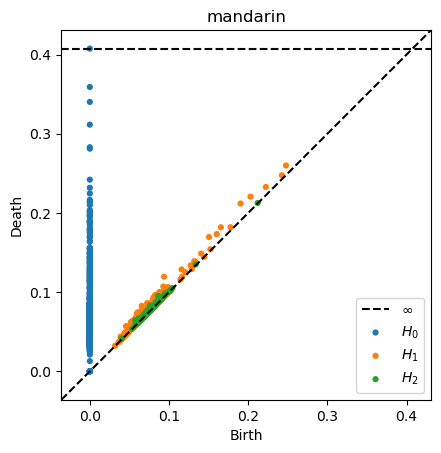

In [20]:
# %%time
rips_3 = Rips(maxdim=2)
data_3 = sub_sampled_embedings_per_lang["zh"]
diagrams_3 = rips_3.fit_transform(data_3, metric="cosine")
rips.plot(diagrams_3)
plt.title("mandarin")

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Text(0.5, 1.0, 'japanese')

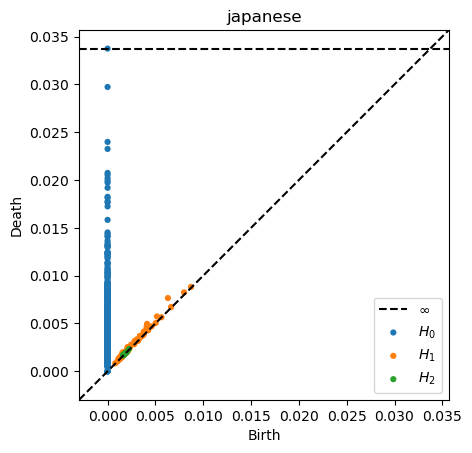

In [21]:
# %%time
rips_4 = Rips(maxdim=2)
data_4 = sub_sampled_embedings_per_lang["ja"]
diagrams_4 = rips_4.fit_transform(data_4, metric="cosine")
rips.plot(diagrams_4)
plt.title("japanese")

Text(0.5, 1.0, 'Japanese')

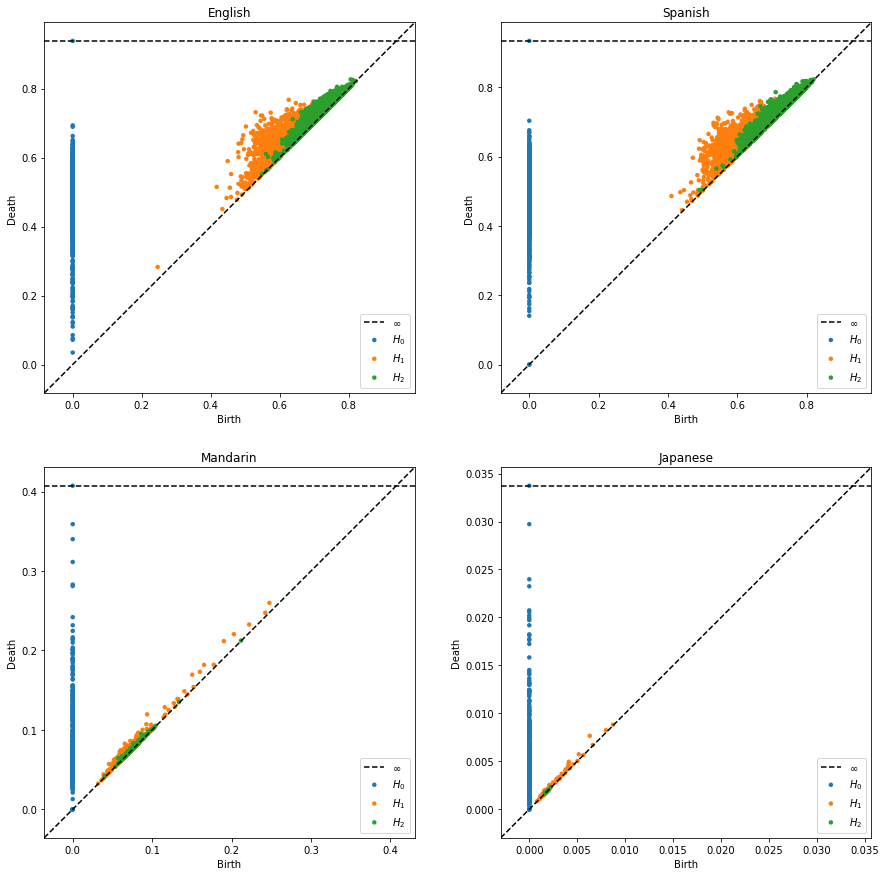

In [22]:
%matplotlib inline

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=False, figsize=(15,15))

plt.axes(ax1)
rips.plot(diagrams)
plt.title("English")
plt.axes(ax2)
rips.plot(diagrams_2)
plt.title("Spanish")
plt.axes(ax3)
rips.plot(diagrams_3)
plt.title("Mandarin")
plt.axes(ax4)
rips.plot(diagrams_4)
plt.title("Japanese")

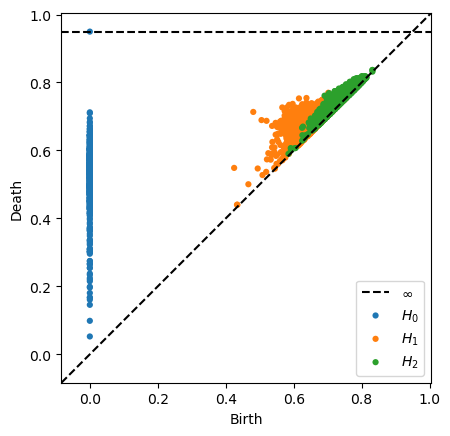

In [51]:
rips.plot(diagrams)


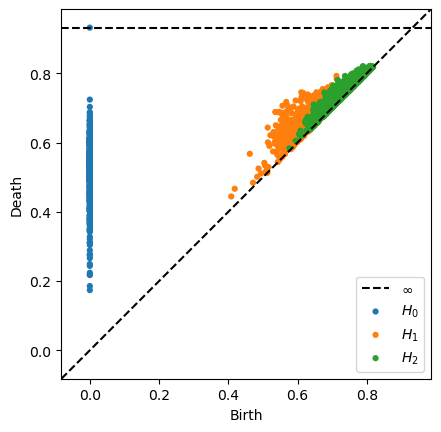

In [52]:
rips.plot(diagrams_2)


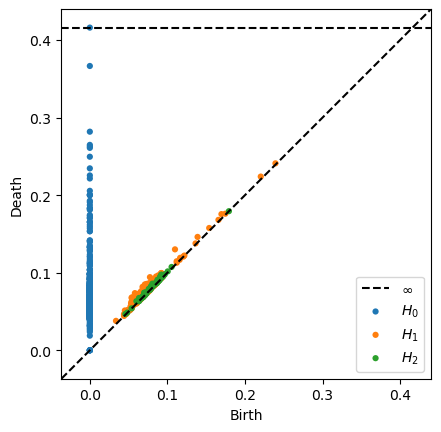

In [53]:
rips.plot(diagrams_3)
